In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

# Synchrotron &mu;-CT reconstruction of mock nuclear fuel with [CIL](https://ccpi.ac.uk/cil/)

In [2]:
# Import packages
import os, math, glob
import numpy as np

# Increase the font size in plots
import matplotlib
font = {'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt # Plotting

# from gvxrPython3 import gvxr # Simulate X-ray images
# from gvxrPython3.utils import loadSpectrumSpekpy, visualise
# from gvxrPython3 import gvxr2json # Simulate X-ray images

import algotom.prep.removal as rem

# CT reconstruction using CIL
from cil.io import TIFFStackReader, TIFFWriter
from cil.utilities.display import show2D, show_geometry
from cil.processors import TransmissionAbsorptionConverter
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.recon import FDK
from cil.plugins.astra import FBP
from cil.optimisation.algorithms import SIRT
from cil.optimisation.functions import IndicatorBox
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.jupyter import islicer
from cil.processors import CentreOfRotationCorrector, Masker, MaskGenerator, RingRemover

In [3]:
use_3D = False

In [4]:
# DONE
scan_number = 112561
scan_energy = 70

# DONE
scan_number = 112555
scan_energy = 90

# DONE
scan_number = 112549
scan_energy = 110

# DONE
scan_number = 112543
scan_energy = 130

# DONE
scan_number = 112530
scan_energy = 150

projection_path = "/run/media/fpvidal/DATA/CT/2022/Diamond_Light_Source/MG-29820/reconstruction/" + str(scan_number) + "/sinogram"

In [5]:
print(projection_path)

/run/media/fpvidal/DATA/CT/2022/Diamond_Light_Source/MG-29820/reconstruction/112530/sinogram


## Set the simulation parameters

In [6]:
# Create the TIFF reader by passing the directory containing the files
fnames = sorted(glob.glob(projection_path + '/slice-*.tif'));

# 3D
if use_3D:
    reader = TIFFStackReader(file_name=fnames, dtype=np.float32)
# 2D
else:
    reader = TIFFStackReader(file_name=fnames[len(fnames) // 2], dtype=np.float32)

# Read in file, and return a numpy array containing the data
data_original = reader.read()

In [7]:
# Create the CIL geoemtry

# 3D
if len(data_original.shape) == 3:
    # The data is stored as a stack of detector images, we use the CILlabels for the axes
    axis_labels = ['vertical','angle','horizontal']
    
    geometry = AcquisitionGeometry.create_Parallel3D(ray_direction=(0.0, -1.0, 0.0),
                                                 detector_position=(0.0, -50.0, 0.0),
                                                 detector_direction_x=(1.0, 0.0, 0.0),
                                                 detector_direction_y=(0.0, 0.0, -1.0),
                                                 rotation_axis_position=(0.0, 0.0, 0.0),
                                                 rotation_axis_direction=(0.0, 0.0, -1.0))   
        
    # Set the angles, remembering to specify the units
    geometry.set_angles(-np.linspace(0, 180, data_original.shape[1]), angle_unit='degree')
    
    # Set the detector shape and size
    geometry.set_panel((data_original.shape[2], len(fnames)), (0.000791, 0.000791))

# 2D
else:
    # The data is stored as a stack of detector images, we use the CILlabels for the axes
    axis_labels = ['angle','horizontal']
    
    geometry = AcquisitionGeometry.create_Parallel2D(ray_direction=(0.0, -1.0),
                                                 detector_position=(0.0, -50.0),
                                                 detector_direction_x=(1.0, 0.0),
                                                 rotation_axis_position=(0.0, 0.0))   
        
    # Set the angles, remembering to specify the units
    geometry.set_angles(-np.linspace(0, 180, data_original.shape[0]), angle_unit='degree')
    
    # Set the detector shape and size
    geometry.set_panel((data_original.shape[1]), (0.000791))
    
# Set the order of the data
geometry.set_labels(axis_labels)

In [8]:
# Prepare the data for the reconstruction
acquisition_data = AcquisitionData(data_original, deep_copy=False, geometry=geometry)
acquisition_data.reorder(order='astra')

In [9]:
# Recentre the sinogram
data_centred = CentreOfRotationCorrector.xcorrelation()(acquisition_data)

In [10]:
# Test various strategies of ring removals

# sigmas = [0.5, 1, 1.5, 2]
# decompositions = [2, 4, 6, 8]
# wavelet_types = ['db1', 'db10', 'db20', 'db30']

# for decomposition in decompositions:
#     for wavelet_type in wavelet_types:
#         for sigma in sigmas:
            
#             ring_remover = RingRemover(decNum=decomposition, wname=wavelet_type, sigma=sigma, info=False);
#             ring_remover.set_input(data_centred)
#             ring_removed = ring_remover.get_output()

#             ig = ring_removed.geometry.get_ImageGeometry()
            
#             ig.voxel_size_x = 0.000791 * 2
#             ig.voxel_size_y = 0.000791 * 2
            
#             ig.voxel_num_x = ig.voxel_num_x // 2
#             ig.voxel_num_y = ig.voxel_num_y // 2
            
#             # 3D
#             if len(data_original.shape) == 3:
            
#                 ig.voxel_size_z = 0.000791 * 2
#                 ig.voxel_num_z = ig.voxel_num_z // 2
            
#             # Perform the FDK reconstruction
#             recon = FBP(ig, ring_removed.geometry, device='gpu')(ring_removed)
#             recon_as_array = recon.as_array()
            
#             fig = plt.figure(figsize=(5,5))
            
#             vmin=2.396-1.5
#             vmax=2.7+0.9
            
#             print(vmax)
#             # 3D
#             if len(data_original.shape) == 3:
#                 plt.imshow(recon_as_array[recon_as_array.shape[0] // 2], cmap="gray", vmin=0.0)
#             # 2D
#             else:
#                 plt.imshow(recon_as_array, cmap="gray", vmin=vmin, vmax=vmax)

#             plt.title('$\sigma = ' + str(sigma) + ', wavelet type =' + wavelet_type + ', $L = $' + str(decomposition))
#             plt.colorbar()
#             plt.axis('off');


In [11]:
# Remove ring artefacts
if use_3D:
    ring_remover = RingRemover(decNum=4, wname="db20", sigma=1.5, info=True);
    ring_remover.set_input(data_centred)
    ring_removed = ring_remover.get_output()
else:
    temp = rem.remove_all_stripe(data_centred.as_array())
    ring_removed = AcquisitionData(temp, geometry=data_centred.geometry)

In [12]:
# Reduce the size of the reconstructed volume
ig = ring_removed.geometry.get_ImageGeometry()

ig.voxel_size_x = 0.000791 * 2
ig.voxel_size_y = 0.000791 * 2

ig.voxel_num_x = ig.voxel_num_x // 2
ig.voxel_num_y = ig.voxel_num_y // 2

# 3D
if len(data_original.shape) == 3:

    ig.voxel_size_z = 0.000791 * 2
    ig.voxel_num_z = ig.voxel_num_z // 2


In [13]:
# Perform the FDK reconstruction
recon = FBP(ig, ring_removed.geometry, device='gpu')(ring_removed)

In [14]:
recon_as_array = recon.as_array()

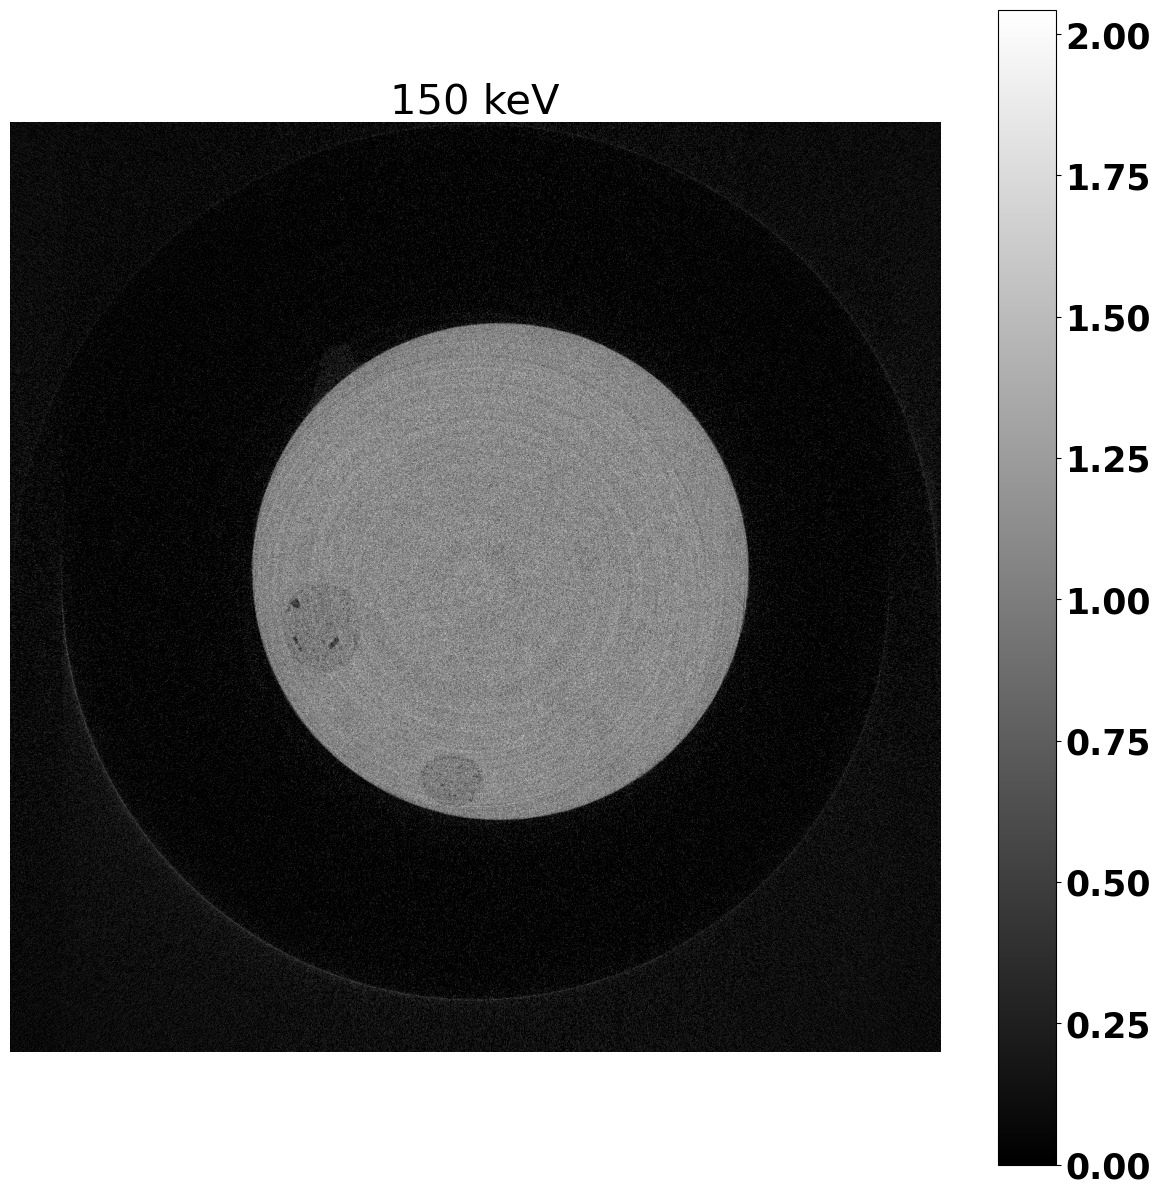

In [15]:
# Plot the centre slice
fig = plt.figure(figsize=(15,15))

# 3D
if len(data_original.shape) == 3:
    plt.imshow(recon_as_array[recon_as_array.shape[0] // 2], cmap="gray", vmin=0.0)
# 2D
else:
    plt.imshow(recon_as_array, cmap="gray", vmin=0.0)
    
plt.colorbar()
plt.axis('off');
plt.title(str(scan_energy) + " keV")
plt.savefig(projection_path + "/../FBP-CIL-" + str(scan_number) + "-" + str(scan_energy) + "keV.png")
plt.savefig(projection_path + "/../FBP-CIL-" + str(scan_number) + "-" + str(scan_energy) + "keV.pdf")

In [16]:
# Save the CT volume as a TIFF stack
TIFFWriter(data=recon, file_name=os.path.join(projection_path + "/../FBP-CIL-" + str(scan_number) + "-" + str(scan_energy) + "keV", "out")).write()
